In [17]:
# Importing modules
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns

# DataFrame for the world
conf_csv = 'covid19_confirmed_global.csv'
conf_df = pd.read_csv(conf_csv)
grouped_conf_df = conf_df.groupby(by = ['Country/Region'], as_index = False).sum()

# DataFrame for India
india_df = pd.read_csv("state_wise.csv")
india_df = india_df.iloc[1:36, :]

# Function to get total confirmed cases in a country
def get_total_confirmed_cases_for_country(country_name):
    total_cases_country = conf_df[conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_cases_country.index = pd.to_datetime(total_cases_country.index)
    return total_cases_country

# Function to get total confirmed cases in the world
def get_total_confirmed_global_cases():
    global_cases = conf_df.iloc[:, 4:].apply(sum, axis=0)
    global_cases.index = pd.to_datetime(global_cases.index)
    return global_cases

# Function to create a line plot
def line_plot(plot_background, fig_width, fig_height, country_name, colour, linewidth, markertype):
    dt_series = None
    if country_name != 'global':
        dt_series = get_total_confirmed_cases_for_country(country_name)
    else:
        dt_series = get_total_confirmed_global_cases()
    plt.style.use(plot_background)
    plt.figure(figsize = (fig_width, fig_height))
    plt.title(f'{country_name.upper()}: Total Coronavirus Cases Reported', fontsize = 16)
    plt.plot(dt_series.index, dt_series, c = colour, lw = linewidth, marker = markertype, markersize = 7)
    plt.xticks(rotation = 45)
    plt.ylabel("Total Cases")
    plt.grid(linestyle='--', c='grey')
    plt.show()

# Add minimap
def add_minimap(map_name):
    # Plugin for mini map
    minimap = plugins.MiniMap(toggle_display = True)
    map_name.add_child(minimap) # Add minimap
    plugins.ScrollZoomToggler().add_to(map_name) # Add scroll zoom toggler to map
    plugins.Fullscreen(position='topright').add_to(map_name) # Add full screen button to map

# Total confirmed cases in the descending order.
grouped_conf_df = conf_df.groupby(by='Country/Region', as_index=False).sum()
desc_grp_conf_df = grouped_conf_df.sort_values(by=conf_df.columns[-1], ascending=False)

# Non-cumulative Confirmed Cases.
non_cum_conf_df = desc_grp_conf_df.iloc[:, :4]
for i in range(len(desc_grp_conf_df.columns[3:]) - 1):
    series = desc_grp_conf_df[desc_grp_conf_df.columns[3 + (i + 1) ]] - desc_grp_conf_df[desc_grp_conf_df.columns[3 + i]]
    non_cum_conf_df[desc_grp_conf_df.columns[3 + (i + 1)]] = series

# Function to get the total non-cumulative confirmed cases in a country.
def get_total_daily_confirmed_cases_for_country(country_name):
    total_daily_cases = non_cum_conf_df[non_cum_conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_daily_cases.index = pd.to_datetime(total_daily_cases.index)
    return total_daily_cases

# Line plot for the daily (non-cumulative) confirmed cases in various countries.
def daily_cases_line_plot(num_countries, width, height):
    plt.figure(figsize=(width, height))
    for region in non_cum_conf_df.iloc[:num_countries, :]['Country/Region']:
        total_conf_cases = get_total_daily_confirmed_cases_for_country(region)
        plt.plot(total_conf_cases.index[53:], total_conf_cases[53:], lw=2.5, label=region)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid('major', linestyle='--', c='grey')
    plt.show()

In [13]:
conf_df[conf_df['Country/Region'] == 'India']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
146,NaN,India,20.593684,78.96288,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,11285561,11308846,11333728,11359048,11385339,11409831,11438734,11474605,11514331,11555284,11599130,11646081,11686796,11734058,11787534,11846652,11908910,11971624,12039644,12095855,12149335,12221665,12303131,12392260,12485509,12589067,12686049,12801785,12928574,13060542,13205926,13358805,13527717,13689453,13873825,14074564,14291917,14526609,14788003,15061805


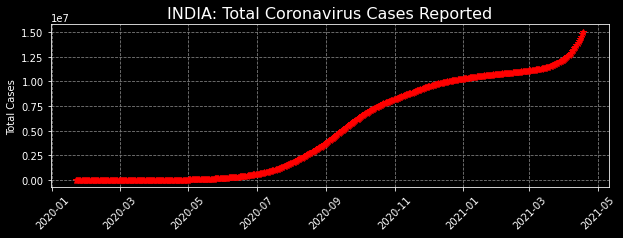

In [14]:
line_plot('dark_background', 10, 3, 'India', 'red', 2, '*')

In [15]:
get_total_daily_confirmed_cases_for_country('India')

2020-01-23         0
2020-01-24         0
2020-01-25         0
2020-01-26         0
2020-01-27         0
               ...  
2021-04-14    200739
2021-04-15    217353
2021-04-16    234692
2021-04-17    261394
2021-04-18    273802
Length: 452, dtype: int64

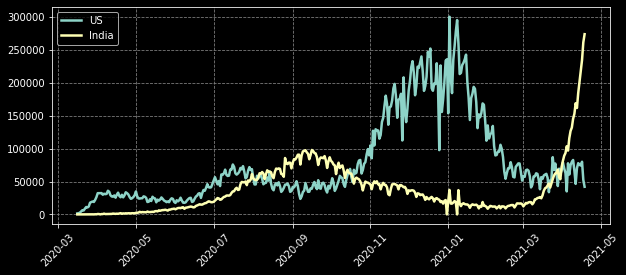

In [16]:
daily_cases_line_plot(2,10,4)